In [1]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr
import numpy as np

import warnings
warnings.filterwarnings("ignore", message="An input array is constant; the correlation coefficient is not defined.")


def pearson_r2(preds, y_true):
    """
    Custom lexical complexity prediction metric consisting in:
    - `(max(0, R^2) + abs(pearson))/2`
    - R^2 - is the standard regression metric, here we do not allow negative values
    - pearson - is the pearson correlation

    A good sollution would:
    - have values that are close to the actual lexical complexity scores
    - have values that are correlated well to the complexity scores
    - one can obtain a good correlation with values that are outside of the range or inversely proportional, we don't care as much
    - a constant predictor will get 0, pearson will be NaN

    """
    r2 = r2_score(y_true, preds, sample_weight=None, force_finite=True)
    r2 = max(0, r2)
    pears = pearsonr(y_true, preds)[0]
    pears = np.nan_to_num(np.array([pears]), copy=False, nan=0)[0]
    pears = np.abs(pears)
    return (pears + r2)/2

def evaluate(predictions, y_true):
    cust = pearson_r2(predictions, y_true)
    return {'r2_pearson': cust}


In [33]:
!python -m spacy download ro_core_news_lg

     ---------------------------------------- 0.0/568.5 MB ? eta -:--:--
     -------------------------------------- 0.0/568.5 MB 653.6 kB/s eta 0:14:30
     -------------------------------------- 0.1/568.5 MB 653.6 kB/s eta 0:14:30
     -------------------------------------- 0.1/568.5 MB 655.4 kB/s eta 0:14:28
     -------------------------------------- 0.1/568.5 MB 654.9 kB/s eta 0:14:28
     -------------------------------------- 0.2/568.5 MB 654.6 kB/s eta 0:14:29
     -------------------------------------- 0.2/568.5 MB 692.4 kB/s eta 0:13:41
     -------------------------------------- 0.2/568.5 MB 722.1 kB/s eta 0:13:08
     -------------------------------------- 0.3/568.5 MB 741.6 kB/s eta 0:12:47
     -------------------------------------- 0.3/568.5 MB 728.0 kB/s eta 0:13:01
     -------------------------------------- 0.3/568.5 MB 723.4 kB/s eta 0:13:06
     -------------------------------------- 0.4/568.5 MB 735.7 kB/s eta 0:12:53
     -------------------------------------- 0.4


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Daniel\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


     --------------------- ---------------- 315.4/568.5 MB 1.0 MB/s eta 0:04:05
     --------------------- ---------------- 315.5/568.5 MB 1.0 MB/s eta 0:04:04
     --------------------- ---------------- 315.6/568.5 MB 1.0 MB/s eta 0:04:03
     --------------------- ---------------- 315.6/568.5 MB 1.0 MB/s eta 0:04:02
     --------------------- ---------------- 315.6/568.5 MB 1.0 MB/s eta 0:04:03
     --------------------- ---------------- 315.7/568.5 MB 1.0 MB/s eta 0:04:03
     --------------------- ---------------- 315.8/568.5 MB 1.0 MB/s eta 0:04:03
     --------------------- ---------------- 315.8/568.5 MB 1.0 MB/s eta 0:04:03
     --------------------- ---------------- 315.8/568.5 MB 1.0 MB/s eta 0:04:04
     --------------------- ---------------- 315.9/568.5 MB 1.0 MB/s eta 0:04:02
     --------------------- ---------------- 316.0/568.5 MB 1.0 MB/s eta 0:04:02
     --------------------- ---------------- 316.0/568.5 MB 1.0 MB/s eta 0:04:02
     --------------------- -------------

In [2]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import os
import math
import spacy
import pyphen

nlp = spacy.load('ro_core_news_lg')
train_data = pd.read_csv('./date/train.csv')
corola_data = pd.read_csv("./date/corola_lemma_freq_gte10_lowercase.tsv", sep=r"\s+", names=["token", "frequency"], engine="python")
train_data['val_sentence'] = train_data['sentence'].apply(nlp)
train_data['val_token'] = train_data['token'].apply(nlp)

Coeficient Pearson: 0.2500, p-valoare: 9.449e-17


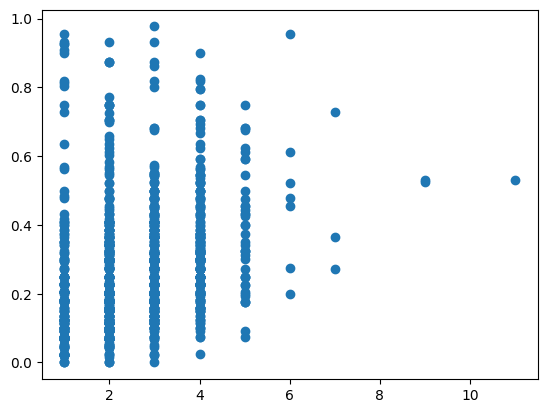

In [3]:
import pyphen
syllaber = pyphen.Pyphen(lang='ro')

def count_syllables(word):
    hyphenated = syllaber.inserted(word[0].lemma_)
    return len(hyphenated.split('-'))
    
train_data['syllable_count'] = train_data['val_token'].apply(count_syllables)

corr, p_value = pearsonr(train_data['syllable_count'], train_data['score'])
print(f"Coeficient Pearson: {corr:.4f}, p-valoare: {p_value:.4g}")

plt.scatter(train_data['syllable_count'],train_data['score'] )
plt.show()

In [42]:
print(corola_data[corola_data['token'].isna()])

      token  frequency
16730   NaN       1202
58576   NaN        121


In [4]:
import math
from scipy.spatial.distance import cosine
count_words_corola = corola_data['frequency'].sum()

x_values = []
corola_vectors = {token: nlp(token)[0].vector for token in corola_data['token'].dropna()}

def find_closest_token(token_vec, corola_vectors):
    min_dist = float('inf')
    best_token = None
    for token, vec in corola_vectors.items():
        dist = cosine(token_vec, vec)
        if dist < min_dist:
            min_dist = dist
            best_token = token
    return best_token
      

for _, row in train_data.iterrows():
    for token_val in row['val_token']:
        lemma = token_val.lemma_.lower()
        frequency = corola_data.loc[corola_data["token"] == lemma, "frequency"]
        if not frequency.empty:
            f = frequency.values[0]
        else:
            if token_val.has_vector:
                closest = find_closest_token(token_val.vector, corola_vectors)
                if closest:
                    f = corola_data.loc[corola_data["token"] == closest, "frequency"].values[0]
                else:
                    f = 1  # fallback final
            else:
                f = 1
        x_values.append(-math.log(f / count_words_corola))


corr, p_value = pearsonr(np.array(x_values), train_data['score'])
print(f"Coeficient Pearson: {corr:.4f}, p-valoare: {p_value:.4g}")
plt.scatter(x_values,train_data['score'] )
plt.show()

KeyboardInterrupt: 

1073 1073
Coeficient Pearson: 0.4550, p-valoare: 6.102e-56


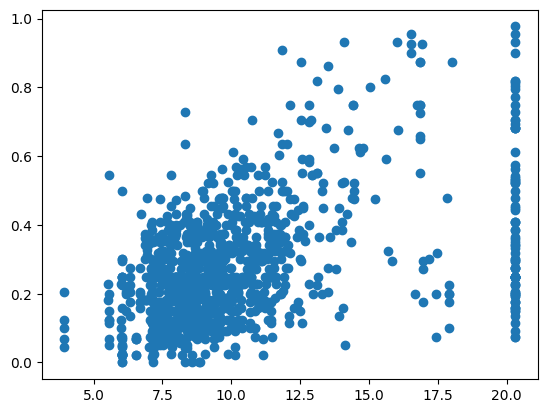

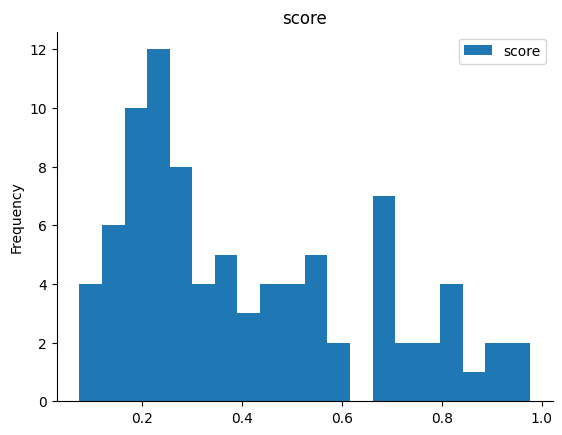

In [5]:
x_values = []
for _, row in train_data.iterrows():
    for token_val in row['val_token']:
        lemma = token_val.lemma_.lower()
        frequency = corola_data.loc[corola_data["token"] == lemma, "frequency"]
        if not frequency.empty:
            f = frequency.values[0]
        else:
            f = 1
        x_values.append(-math.log(f / count_words_corola))
print(len(np.array(x_values)),len(train_data['score']))
corr, p_value = pearsonr(np.array(x_values), train_data['score'])
print(f"Coeficient Pearson: {corr:.4f}, p-valoare: {p_value:.4g}")
plt.scatter(x_values,train_data['score'] )
plt.show()

train_data.loc[[i for i, x in enumerate(x_values) if x > 18], ['val_token', 'score']].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)


In [12]:
aux = train_data['score'][[i for i,x in enumerate(x_values) if x > 18]]
print(aux.sum()/len(aux))

print(len(train_data['val_token'][[i for i,x in enumerate(x_values) if x > 18]]))
print(train_data['val_token'][[i for i,x in enumerate(x_values) if x > 18]])

0.3757364771279004
137
8          (cercetare)
9          (colectare)
30        (urma-urmei)
33      (desfășurându)
45        (grupurilor)
             ...      
1033    (algoritmilor)
1046        (perechii)
1049      (profesoară)
1054        (arbuștii)
1063      (sateloidul)
Name: val_token, Length: 137, dtype: object


Coeficient Pearson: 0.4697, p-valoare: 5.45e-60


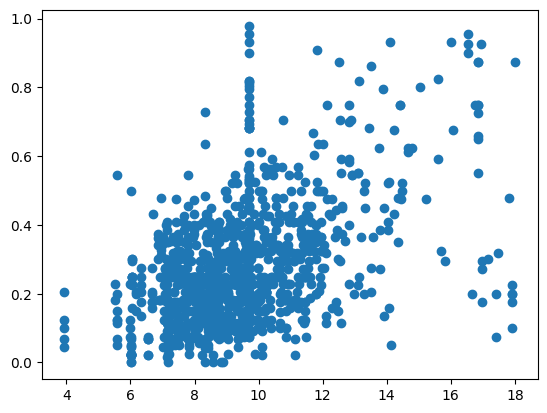

In [6]:
x_values = []
for _, row in train_data.iterrows():
    for token_val in row['val_token']:
        lemma = token_val.lemma_.lower()
        frequency = corola_data.loc[corola_data["token"] == lemma, "frequency"]
        if not frequency.empty:
            x_values.append(-math.log(frequency.values[0]/ count_words_corola))
        else:
           #intre scorile 0,2 si 0,4 diferenta 0,2 iar pentru scorile 0,2 === 7,5 iar 0,4 === 10 => 0.3757364771279004-0,2 * 2,5 / 0.2 + 7,5
           x_values.append(9.6967059641)        

corr, p_value = pearsonr(np.array(x_values), train_data['score'])
print(f"Coeficient Pearson: {corr:.4f}, p-valoare: {p_value:.4g}")
plt.scatter(x_values,train_data['score'] )
plt.show()

Coeficient Pearson: 0.2804, p-valoare: 7.651e-21


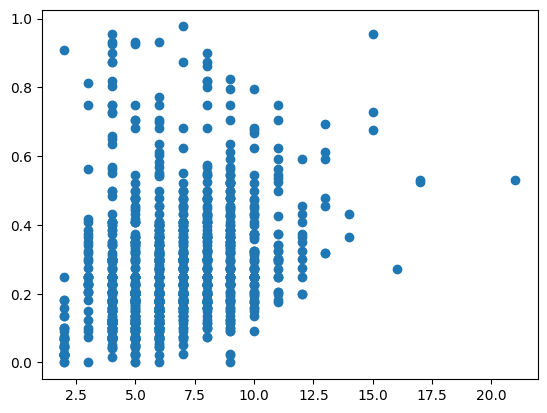

In [17]:
x_values = []
for _, row in train_data.iterrows():
    for token_val in row['val_token']:
        lemma = token_val.lemma_.lower()
        x_values.append(len(lemma))        

corr, p_value = pearsonr(np.array(x_values), train_data['score'])
print(f"Coeficient Pearson: {corr:.4f}, p-valoare: {p_value:.4g}")
plt.scatter(x_values,train_data['score'] )
plt.show()

In [7]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

x_values = []
for _, row in train_data.iterrows():
    for token_val in row['val_token']:
        lemma = token_val.lemma_.lower()
        frequency = corola_data.loc[corola_data["token"] == lemma, "frequency"]
        if not frequency.empty:
            x_values.append(-math.log(frequency.values[0]/ count_words_corola))
        else:
           #intre scorile 0,2 si 0,4 diferenta 0,2 iar pentru scorile 0,2 === 7,5 iar 0,4 === 10 => 0.3757364771279004-0,2 * 2,5 / 0.2 + 7,5
           x_values.append(9.6967059641)  
           
train_data["avg_token_freq_score"] = x_values    
train_data['syllable_count'] = train_data['val_token'].apply(count_syllables)

x_values = []
for _, row in train_data.iterrows():
    for token_val in row['val_token']:
        lemma = token_val.lemma_.lower()
        x_values.append(len(lemma))  
train_data["len_freq_score"] = x_values   

X = train_data.drop(columns=["score",'val_sentence','val_token','sentence','token'])  # toate coloanele în afară de scor
y = train_data["score"]

# împărțim în train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🧠 modelul Gradient Boosting
model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    loss='huber',  # robust la outlieri
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

evaluate(y_pred,y_test)

{'r2_pearson': 0.3913342357049974}

MAE: 0.1049


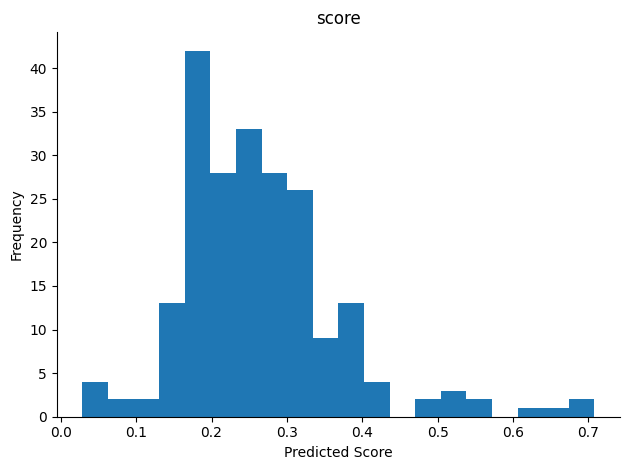

In [22]:
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
y_pred = pd.Series(y_pred)

# plot
y_pred.plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xlabel("Predicted Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [8]:
test_data = pd.read_csv('./date/test.csv')
test_data['val_token'] = test_data['token'].apply(nlp)

x_values = []
for _, row in test_data.iterrows():
    for token_val in row['val_token']:
        lemma = token_val.lemma_.lower()
        frequency = corola_data.loc[corola_data["token"] == lemma, "frequency"]
        if not frequency.empty:
            x_values.append(-math.log(frequency.values[0]/ count_words_corola))
        else:
           #intre scorile 0,2 si 0,4 diferenta 0,2 iar pentru scorile 0,2 === 7,5 iar 0,4 === 10 => 0.3757364771279004-0,2 * 2,5 / 0.2 + 7,5
           x_values.append(9.6967059641)  
           
test_data["avg_token_freq_score"] = x_values    
test_data['syllable_count'] = test_data['val_token'].apply(count_syllables)

x_values = []
for _, row in test_data.iterrows():
    for token_val in row['val_token']:
        lemma = token_val.lemma_.lower()
        x_values.append(len(lemma))  
test_data["len_freq_score"] = x_values  

X_test = test_data.drop(columns=['val_token','sentence','token'])

print(X_train.columns,X_test.columns)
X_test = X_test[X_train.columns]
y_pred = model.predict(X_test)

df_output = pd.DataFrame({
    "Id": test_data.index,  # presupunem că indexul din test.csv este Id-ul
    "complexity": y_pred
})

# Salvează în CSV
df_output.to_csv("predicted_gradient.csv", index=False)

Index(['Id', 'syllable_count', 'avg_token_freq_score', 'len_freq_score'], dtype='object') Index(['Id', 'avg_token_freq_score', 'syllable_count', 'len_freq_score'], dtype='object')


['haina', 'zilele', 'putem', 'copacilor', 'copăcei', 'ochilor', 'Pământul', 'întoarce', 'Dumnezeule', 'ani', 'vedea', 'ani', 'lucruri', 'luni', 'puse', 'statui', 'avem', 'săptămânii', 'mers', 'oameni', 'obținut', 'ochilor', 'săptămâna', 'anul', 'mâna', 'anii', 'dispăruseră', 'dimineață', 'putem', 'Soarele', 'locuri', 'zile', 'spune', 'zile', 'prietenele', 'oceanul', 'cuvinte', 'ochilor', 'mâna', 'ani', 'numele', 'culoare', 'săptămâni', 'munte', 'spus', 'povestea', 'pielea', 'ochii', 'ajuta', 'rămas', 'ocean', 'număr', 'succes', 'spunem', 'adus', 'cuvintelor', 'timpul', 'Cartea', 'ani', 'păsări', 'Obiectul', 'ajuns', 'zile', 'ani', 'zile', 'Timp', 'hainele', 'Titlul', 'început', 'Echipa', 'lucru', 'ani', 'folosită', 'oamenilor', 'Soarele', 'pământ', 'ani', 'oameni', 'ani', 'spus', 'scrisă', 'kilograme', 'Luna', 'ani', 'face', 'există', 'joc', 'grup', 'ochiul', 'imagine', 'ani', 'ani', 'grup', 'ziarul', 'haina', 'Luna', 'căsătoriei', 'culoare', 'oamenii', 'animalele', 'femeii', 'avut', '

ValueError: x and y must be the same size

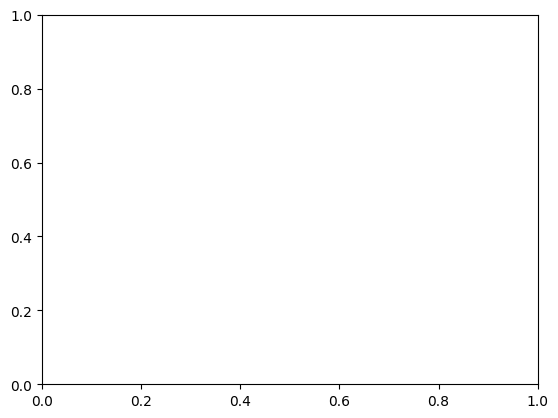

In [ ]:
easy_words = train_data.loc[train_data["score"] < 0.1, "token"].tolist()
hard_words = train_data.loc[train_data["score"] > 0.6, "token"].tolist()
print(easy_words)
print(hard_words)
sim_easy, sim_hard = [], []

for _, row in train_data.iterrows():
    for token in row['token']:
        doc_token = nlp(token)
        if doc_token.vector_norm == 0:
            continue  # sărim tokenii fără vector

        # Similaritate cu easy_words (doar dacă și cuvintele au vector)
        sims_easy = [nlp(w).similarity(doc_token) for w in easy_words if nlp(w).vector_norm > 0]
        if sims_easy:
            sim_easy.append(np.mean(sims_easy))
        else:
            sim_easy.append(0)

        # Similaritate cu hard_words (doar dacă și cuvintele au vector)
        sims_hard = [nlp(w).similarity(doc_token) for w in hard_words if nlp(w).vector_norm > 0]
        if sims_hard:
            sim_hard.append(np.mean(sims_hard))
        else:
            sim_hard.append(0)



eye-tracking
dw {'AUX', 'CCONJ', 'X', 'NUM', 'VERB', 'ADV', 'INTJ', 'ADJ', 'PROPN', 'NOUN'}


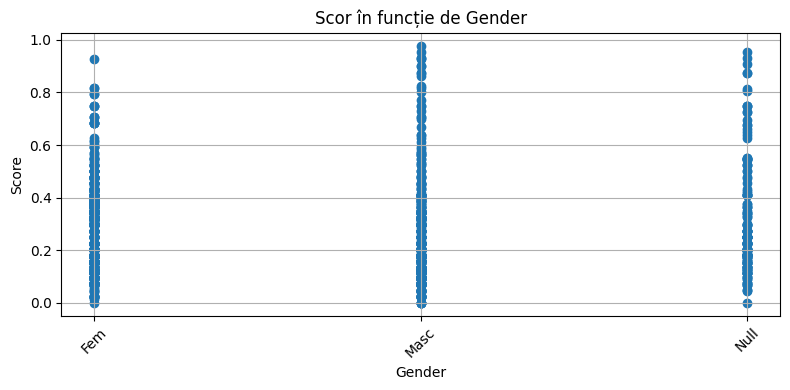

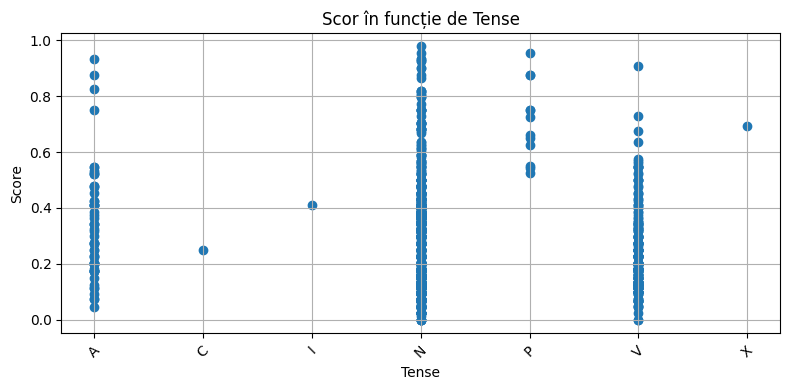

In [65]:
gender, tense = [], []
set_d = set()

for row in train_data['val_token']:
    text = row[0]  # primul token din fiecare listă
    g = text.morph.get("Gender")
    t = text.pos_
    set_d.add(text.pos_)
    gender.append(g[0] if g else 'Null')
    if text.pos_ == "X":
        print(text)
    tense.append(t[0] if t else 'Null')

gender_series = pd.Series(gender).astype("category")
tense_series = pd.Series(tense).astype("category")
print("dw",set_d)
# Atribuim coduri numerice pentru plotting
gender_codes = gender_series.cat.codes
tense_codes = tense_series.cat.codes

# Plot
plt.figure(figsize=(8,4))
plt.scatter(gender_codes, train_data['score'])
plt.xticks(ticks=range(len(gender_series.cat.categories)), labels=gender_series.cat.categories, rotation=45)
plt.title("Scor în funcție de Gender")
plt.xlabel("Gender")
plt.ylabel("Score")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.scatter(tense_codes, train_data['score'])
plt.xticks(ticks=range(len(tense_series.cat.categories)), labels=tense_series.cat.categories, rotation=45)
plt.title("Scor în funcție de Tense")
plt.xlabel("Tense")
plt.ylabel("Score")
plt.grid(True)
plt.tight_layout()
plt.show()

In [66]:
print(train_data.columns)

Index(['Id', 'sentence', 'token', 'score', 'val_sentence', 'val_token'], dtype='object')


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score

# Presupunem că ai un DataFrame numit train_data
x_values = []
for _, row in train_data.iterrows():
    for token_val in row['val_token']:
        lemma = token_val.lemma_.lower()
        frequency = corola_data.loc[corola_data["token"] == lemma, "frequency"]
        if not frequency.empty:
            x_values.append(-math.log(frequency.values[0]/ count_words_corola))
        else:
           #intre scorile 0,2 si 0,4 diferenta 0,2 iar pentru scorile 0,2 === 7,5 iar 0,4 === 10 => 0.3757364771279004-0,2 * 2,5 / 0.2 + 7,5
           x_values.append(9.6967059641)  
           
train_data["avg_token_freq_score"] = x_values  
x_values = []
for _, row in train_data.iterrows():
    for token_val in row['val_token']:
        lemma = token_val.lemma_.lower()
        x_values.append(len(lemma))       
train_data["len_lemma_token"] = x_values         
x_values = []
for row in train_data['val_token']:
    c = 0
    text = row[0]
    if text.pos_ == 'X' or  text.pos_ == 'PROPN':
        c = 1
    x_values.append(c)
train_data["pos_token"] = x_values   

X = train_data[['avg_token_freq_score', 'len_lemma_token', 'pos_token']] 
y = train_data['score']  # variabila dependentă

# Split în train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38)

# Model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictii
y_pred = model.predict(X_test)

# Evaluare
print("Coeficienți:", model.coef_)
print("Intercept:", model.intercept_)


Coeficienți: [0.02994946 0.01463733 0.25707642]
Intercept: -0.10296378092866354


RMSE: 0.1626710452638922
R²: 0.2773134491673892
Coeficient Pearson: 0.5272, p-valoare: 8.824e-17


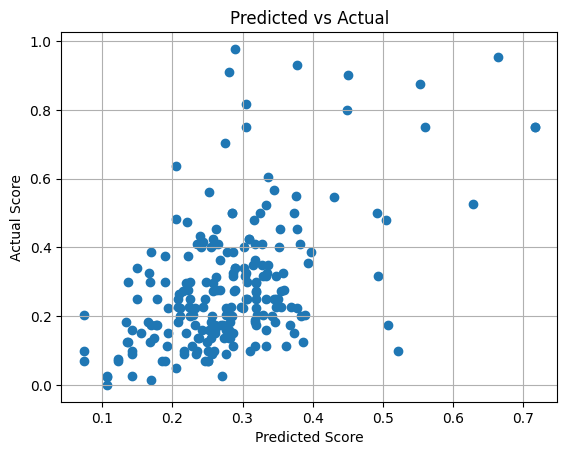

In [69]:
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
corr, p_value = pearsonr(y_pred, y_test)

print("RMSE:", rmse)
print("R²:", r2)
print(f"Coeficient Pearson: {corr:.4f}, p-valoare: {p_value:.4g}")

# Plot: pred vs real
plt.scatter(y_pred, y_test)
plt.xlabel("Predicted Score")
plt.ylabel("Actual Score")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.show()

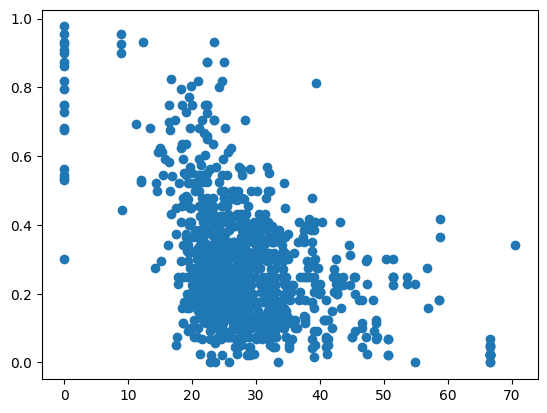

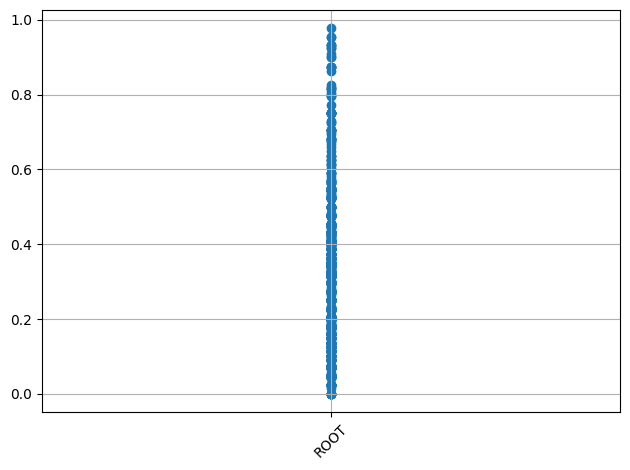

In [11]:
dependency = []
norm = []
set_d = set()

for row in train_data['val_token']:
    text = row[0]  # primul token din fiecare listă
    norm.append(text.vector_norm )
    dependency.append(text.dep_)

dependency_series = pd.Series(dependency).astype("category")
# tense_series = pd.Series(tense).astype("category")
# print("dw",set_d)
# # Atribuim coduri numerice pentru plotting
dependency_codes = dependency_series.cat.codes
# tense_codes = tense_series.cat.codes

plt.scatter(norm, train_data['score'])
plt.show()
# # Plot
# plt.figure(figsize=(8,4))
plt.scatter(dependency_codes, train_data['score'])
plt.xticks(ticks=range(len(dependency_series.cat.categories)), labels=dependency_series.cat.categories, rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

Coeficienți: [ 0.02305201  0.00653086  0.25427333 -0.00421872]
Intercept: 0.13462186422979017
RMSE: 0.1548233612937427
R²: 0.3453601450252217
Coeficient Pearson: 0.5883, p-valoare: 2.067e-21


C:\Users\Daniel\AppData\Local\Temp\ipykernel_21296\1738083965.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['l2_vector_norm'] = norm


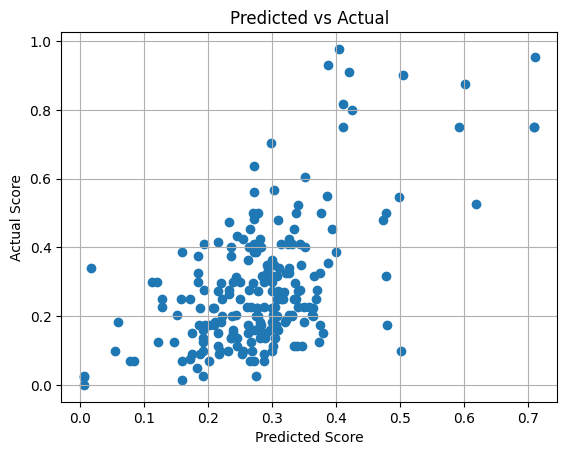

In [12]:
X['l2_vector_norm'] = norm
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38)

model = LinearRegression()
model.fit(X_train, y_train)

# Predictii
y_pred = model.predict(X_test)
# Evaluare
print("Coeficienți:", model.coef_)
print("Intercept:", model.intercept_)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
corr, p_value = pearsonr(y_pred, y_test)

print("RMSE:", rmse)
print("R²:", r2)
print(f"Coeficient Pearson: {corr:.4f}, p-valoare: {p_value:.4g}")

# Plot: pred vs real
plt.scatter(y_pred, y_test)
plt.xlabel("Predicted Score")
plt.ylabel("Actual Score")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.show()

In [13]:
print(X.columns)

model = LinearRegression()
model.fit(X, y)

norm = []
for row in test_data['val_token']:
    text = row[0]  # primul token din fiecare listă
    norm.append(text.vector_norm )
test_data['l2_vector_norm'] = norm
x_values = []
for _, row in test_data.iterrows():
    for token_val in row['val_token']:
        lemma = token_val.lemma_.lower()
        x_values.append(len(lemma))       
test_data["len_lemma_token"] = x_values         
x_values = []
for row in test_data['val_token']:
    c = 0
    text = row[0]
    if text.pos_ == 'X' or  text.pos_ == 'PROPN':
        c = 1
    x_values.append(c)
test_data["pos_token"] = x_values

X_test = test_data[['avg_token_freq_score', 'len_lemma_token', 'pos_token','l2_vector_norm']] 
X_test = X_test[X.columns]
y_pred = model.predict(X_test)

df_output = pd.DataFrame({
    "Id": test_data.index,  # presupunem că indexul din test.csv este Id-ul
    "complexity": y_pred
})

# Salvează în CSV
df_output.to_csv("predicted_multilinear.csv", index=False)


Index(['avg_token_freq_score', 'len_lemma_token', 'pos_token',
       'l2_vector_norm'],
      dtype='object')


In [14]:
norm = []
set_d = set()

for row in train_data['val_token']:
    text = row[0]  # primul token din fiecare listă
    norm.append(text.vector_norm )
    dependency.append(text.dep_)
    
corr, p_value = pearsonr(norm, train_data['score'])
print(f"Coeficient Pearson: {corr:.4f}, p-valoare: {p_value:.4g}")

Coeficient Pearson: -0.4617, p-valoare: 9.318e-58


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

C:\Users\Daniel\AppData\Local\Temp\ipykernel_21296\3999579850.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['oov'] = l


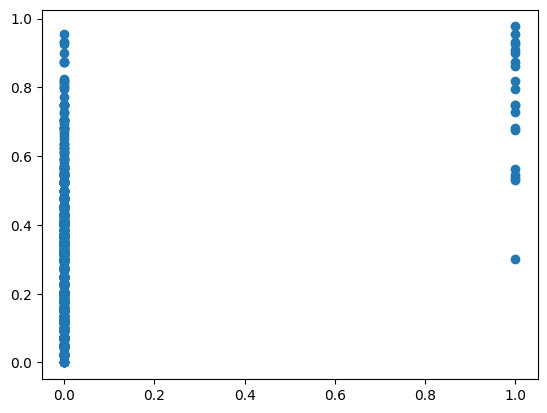

In [15]:
l = []
for row in train_data['val_token']:
    text = row[0]  # primul token din fiecare listă
    if text.is_oov:
        l.append(1)
    else:
        l.append(0)
X['oov'] = l
    
print(l)
# max_l = max(l)
# print(max_l)
# l = [x/max_l for x in l]
plt.scatter(l,train_data['score'])
plt.show()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38)

model = LinearRegression()
model.fit(X_train, y_train)

# Predictii
y_pred = model.predict(X_test)
# Evaluare
print("Coeficienți:", model.coef_)
print("Intercept:", model.intercept_)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
corr, p_value = pearsonr(y_pred, y_test)

print("RMSE:", rmse)
print("R²:", r2)
print(f"Coeficient Pearson: {corr:.4f}, p-valoare: {p_value:.4g}")


Coeficienți: [ 0.0251813   0.00744685  0.26135719 -0.00246801  0.28760799]
Intercept: 0.05525736650925442
RMSE: 0.14159765566877644
R²: 0.45242755648081867
Coeficient Pearson: 0.6730, p-valoare: 1.028e-29


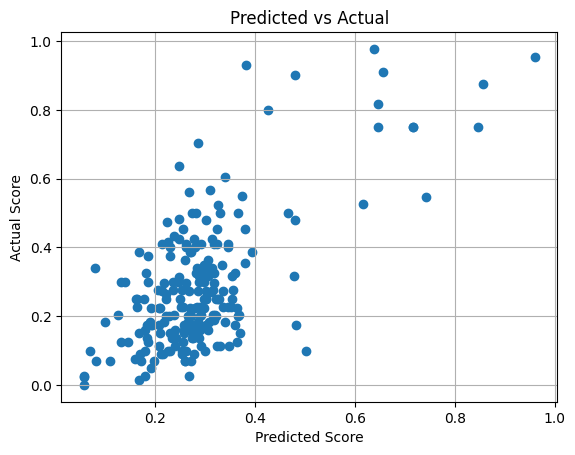

In [110]:
plt.scatter(y_pred, y_test)
plt.xlabel("Predicted Score")
plt.ylabel("Actual Score")
plt.title("Predicted vs Actual")
plt.grid(True)
plt.show()

In [17]:
print(X.columns)
X1 = X.drop(columns=['len_lemma_token'])
print(X1.columns)
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=38)

model = LinearRegression()
model.fit(X_train, y_train)

# Predictii
y_pred = model.predict(X_test)
# Evaluare
print("Coeficienți:", model.coef_)
print("Intercept:", model.intercept_)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
corr, p_value = pearsonr(y_pred, y_test)

print("RMSE:", rmse)
print("R²:", r2)
print(f"Coeficient Pearson: {corr:.4f}, p-valoare: {p_value:.4g}")

Index(['avg_token_freq_score', 'len_lemma_token', 'pos_token',
       'l2_vector_norm', 'oov'],
      dtype='object')
Index(['avg_token_freq_score', 'pos_token', 'l2_vector_norm', 'oov'], dtype='object')
Coeficienți: [ 0.02446676  0.24778    -0.00381433  0.28012639]
Intercept: 0.14951866317510837
RMSE: 0.1411913178161348
R²: 0.45556574631054947
Coeficient Pearson: 0.6756, p-valoare: 5.084e-30


In [18]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    corr, p_value = pearsonr(y_pred, y_test)

    print("RMSE:", rmse)
    print("R²:", r2)
    print(f"Coeficient Pearson: {corr:.4f}, p-valoare: {p_value:.4g}")
    return y_pred

In [21]:
from sklearn.ensemble import RandomForestRegressor

print(X_train.columns)
rf_model = RandomForestRegressor(criterion='poisson',random_state=42)
rf_model.fit(X_train, y_train)

print("=== Random Forest ===")
y_pred_rf = evaluate_model(rf_model, X_test, y_test)


Index(['avg_token_freq_score', 'len_lemma_token', 'pos_token',
       'l2_vector_norm', 'oov'],
      dtype='object')
=== Random Forest ===
RMSE: 0.1371411714327433
R²: 0.486352513091897
Coeficient Pearson: 0.7002, p-valoare: 5.245e-33


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=38)

print(X_train.columns)
rf_model = RandomForestRegressor(criterion='poisson',random_state=42)
rf_model.fit(X_train, y_train)

print("=== Random Forest ===")
y_pred_rf = evaluate_model(rf_model, X_test, y_test)

Index(['avg_token_freq_score', 'len_lemma_token', 'pos_token',
       'l2_vector_norm', 'oov'],
      dtype='object')
=== Random Forest ===
RMSE: 0.12977685403999742
R²: 0.5400358939954936
Coeficient Pearson: 0.7361, p-valoare: 5.929e-38


In [26]:
rf_model = RandomForestRegressor(criterion='poisson',random_state=42)
rf_model.fit(X.drop(columns=['oov']), y)


l = []
for row in test_data['val_token']:
    text = row[0]  # primul token din fiecare listă
    if text.is_oov:
        l.append(1)
    else:
        l.append(0)
test_data['oov'] = l

X_test = test_data[['avg_token_freq_score', 'len_lemma_token','pos_token', 'l2_vector_norm']] 
X_test = X_test[X.drop(columns=['oov']).columns]
y_pred = rf_model.predict(X_test)

df_output = pd.DataFrame({
    "Id": test_data.index,  # presupunem că indexul din test.csv este Id-ul
    "complexity": y_pred
})

# Salvează în CSV
df_output.to_csv("predicted_randomForest3.csv", index=False)

In [170]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(loss='huber',random_state=42)
gb_model.fit(X_train, y_train)

print("=== Gradient Boosting ===")
y_pred_gb = evaluate_model(gb_model, X_test, y_test)



=== Gradient Boosting ===
RMSE: 0.13698173609668707
R²: 0.48754611462815567
Coeficient Pearson: 0.6985, p-valoare: 8.68e-33


{'Number', 'VerbForm', 'Tense', 'Person', 'Mood'}


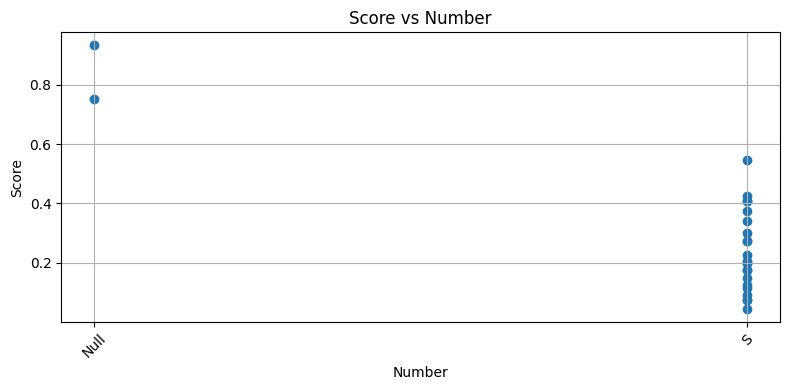

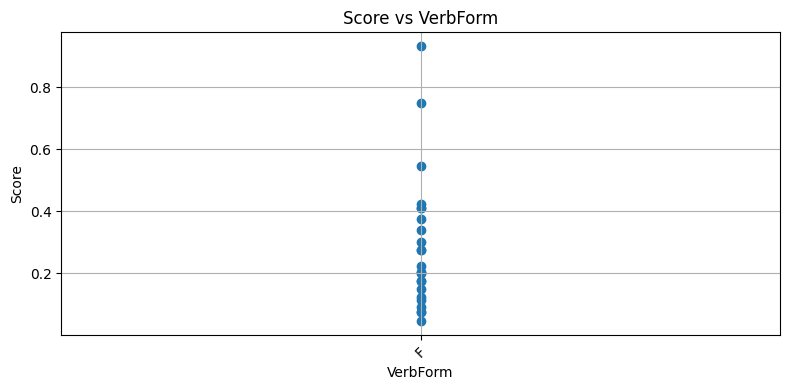

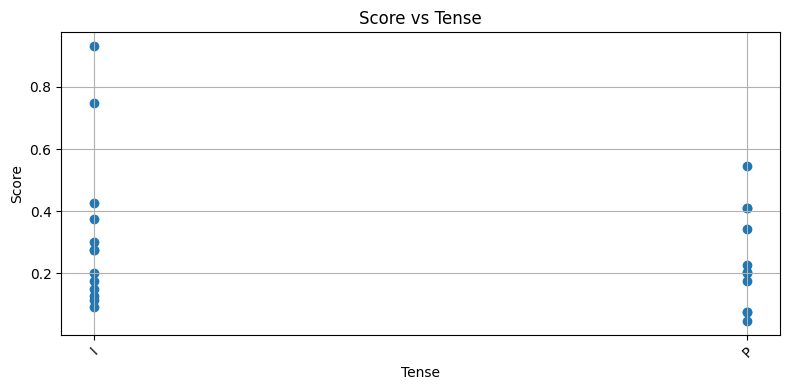

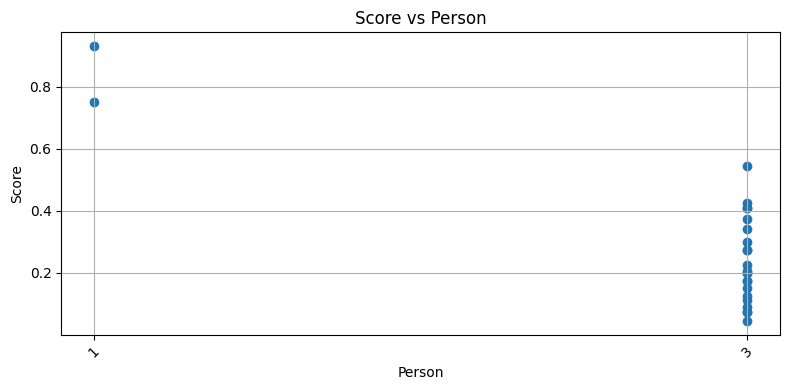

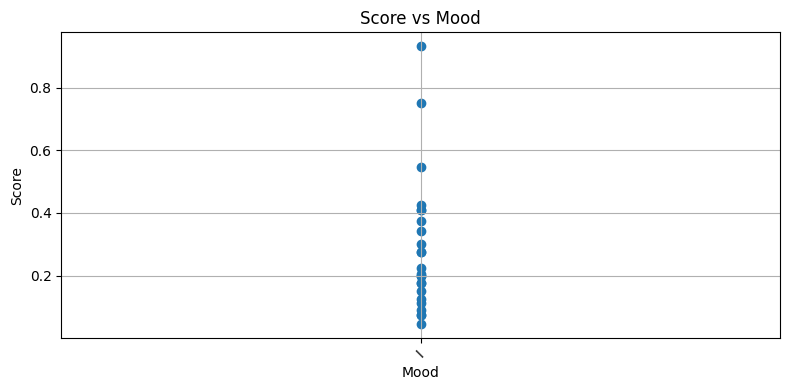

In [152]:
#{'AUX', 'CCONJ', 'X', 'NUM', 'VERB', 'ADV', 'INTJ', 'ADJ', 'PROPN', 'NOUN'}
def plot_morph(pos):
    morfologie_set = set()
    for row in train_data['val_token']:
        if row[0].pos_ == pos:
            morfologie_set.update(row[0].morph.to_dict().keys())

    print(morfologie_set)

    morfologie_dict = {key: [] for key in morfologie_set}

    x1, y1 = [], []
    for i, row in enumerate(train_data['val_token']):
        if row[0].pos_ == pos:
            current_keys = row[0].morph.to_dict()
            for key in morfologie_set:
                values = current_keys.get(key, [])
                morfologie_dict[key].append(values[0] if values else 'Null')
            y1.append(train_data['score'][i])

    for feature in morfologie_dict:
        try:
            feature_series = pd.Series(morfologie_dict[feature]).astype('category')
            codes = feature_series.cat.codes

            plt.figure(figsize=(8, 4))
            plt.scatter(codes, y1)
            plt.xticks(ticks=range(len(feature_series.cat.categories)),
                    labels=feature_series.cat.categories, rotation=45)
            plt.xlabel(feature)
            plt.ylabel("Score")
            plt.title(f"Score vs {feature}")
            plt.tight_layout()
            plt.grid(True)
            plt.show()
        except Exception as e:
            print(f"⚠️ Eroare la feature-ul '{feature}': {e}")

plot_morph('AUX')

{'Polarity'}


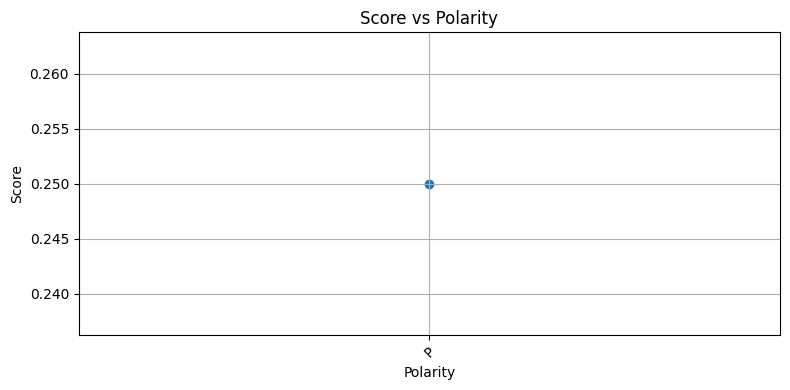

{'NumType', 'Number', 'NumForm'}


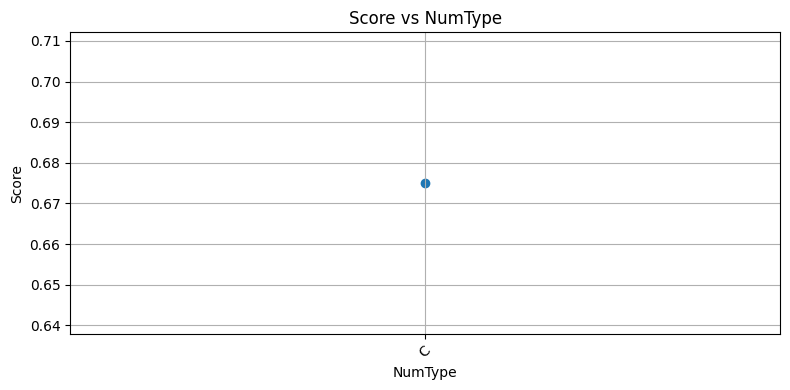

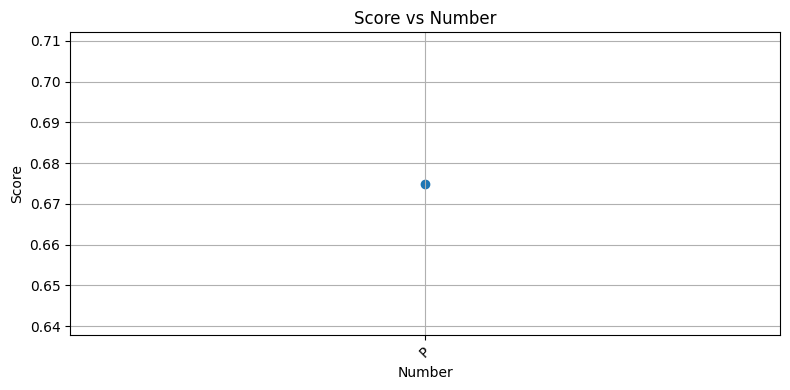

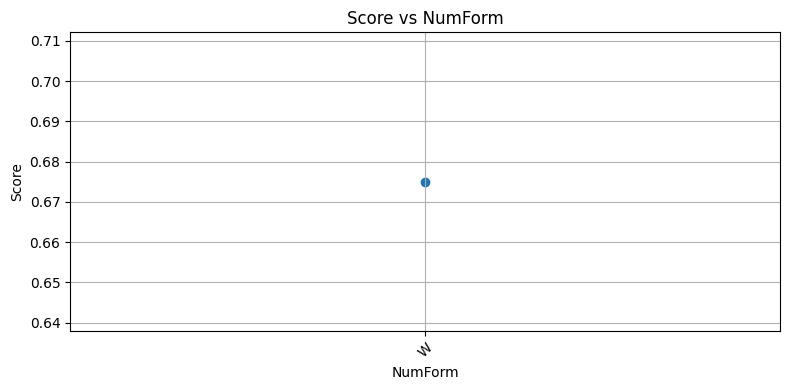

In [ ]:
plot_morph('CCONJ')
plot_morph('NUM')
plot_morph('ADV')

{'Variant', 'Number', 'VerbForm', 'Tense', 'Person', 'Gender', 'Mood'}


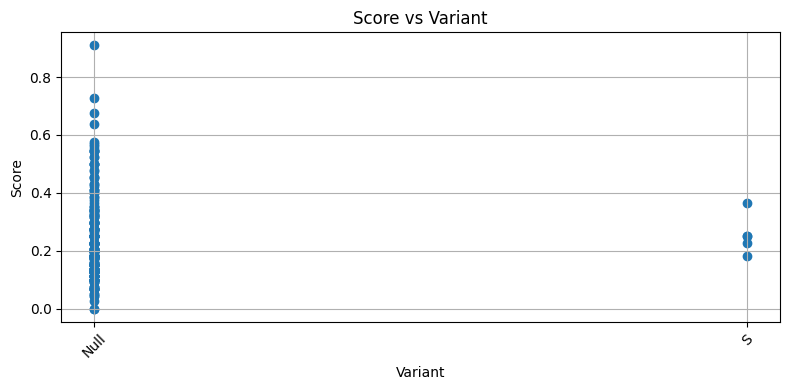

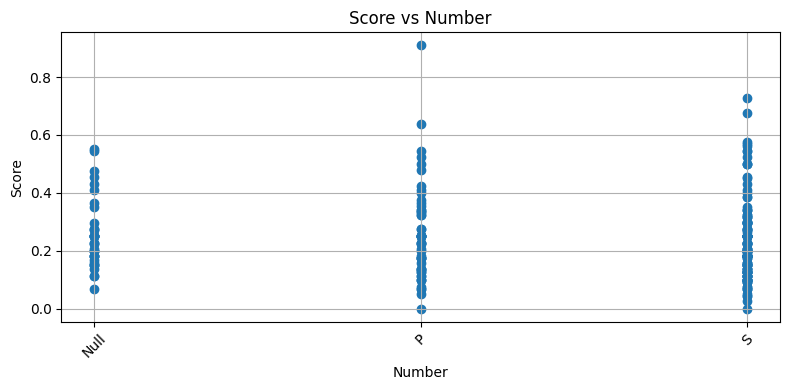

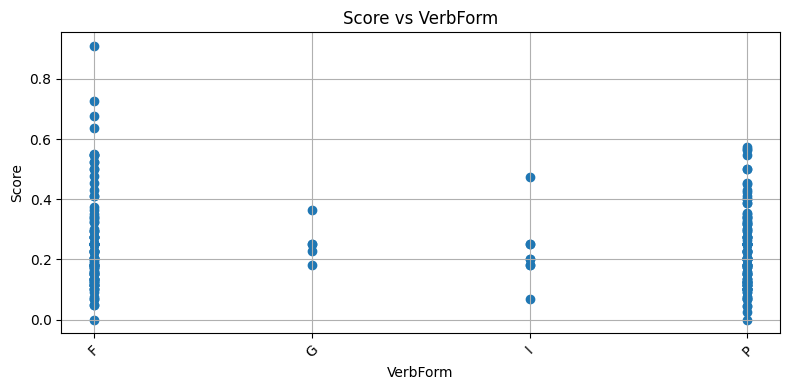

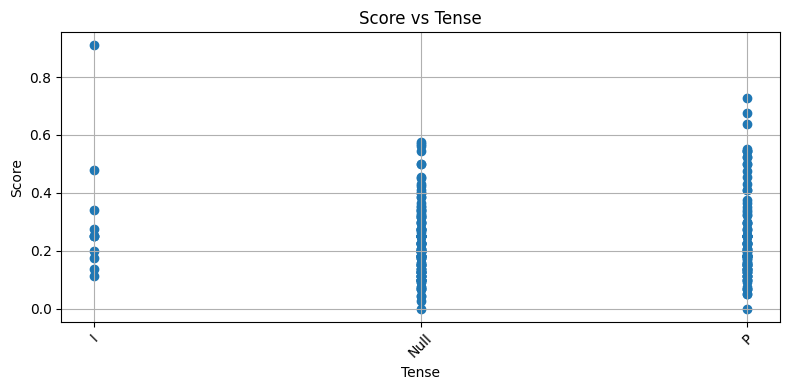

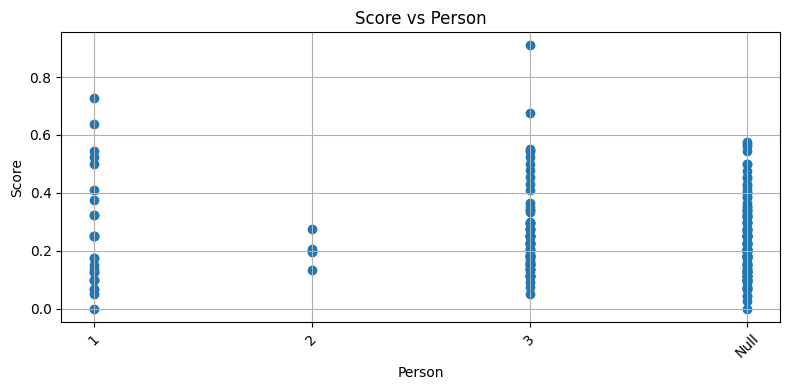

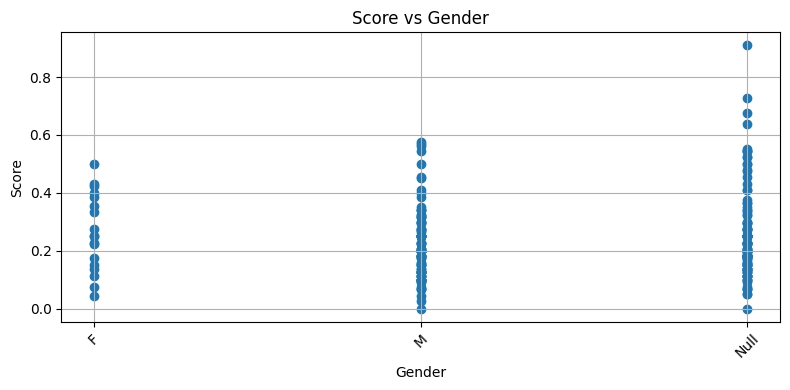

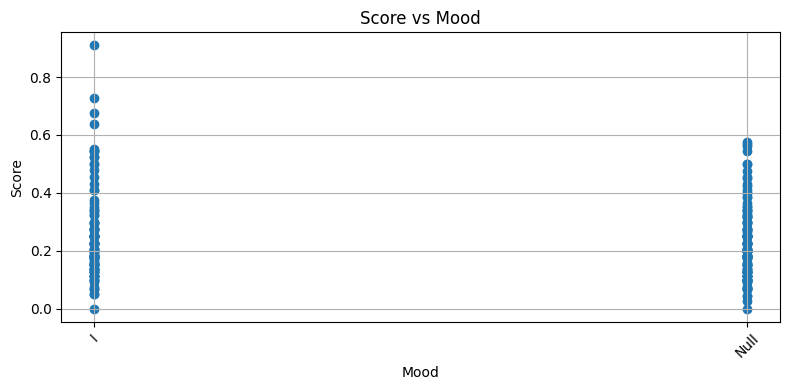

In [155]:
plot_morph('VERB')

{'Number', 'Gender', 'Case', 'Definite', 'Degree'}


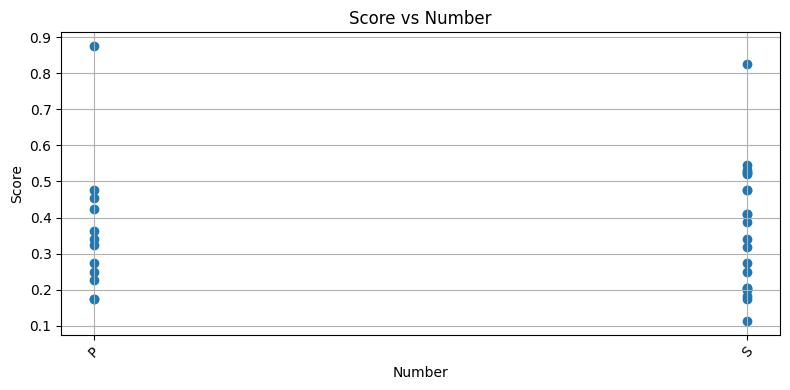

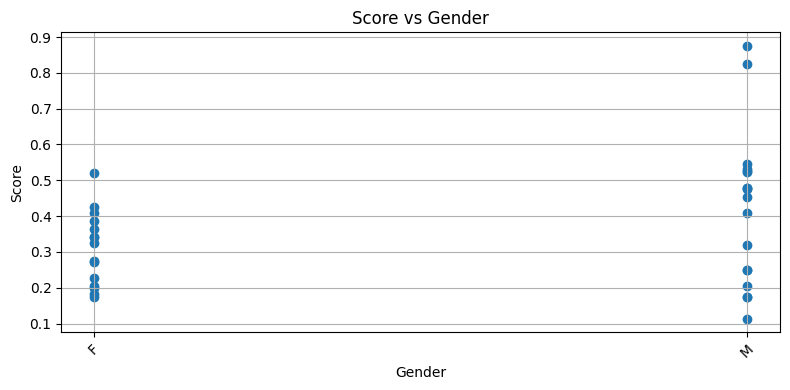

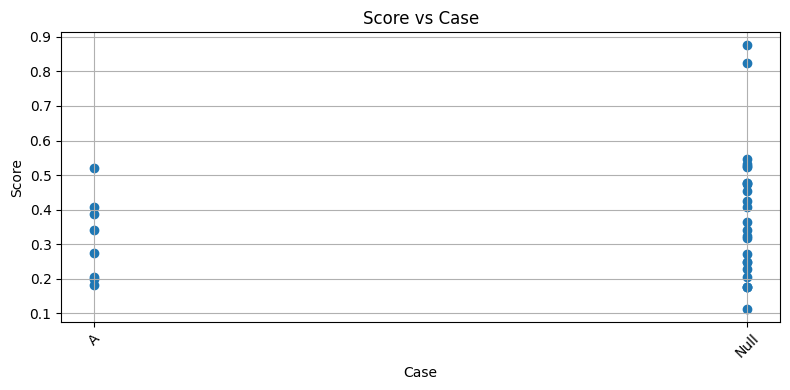

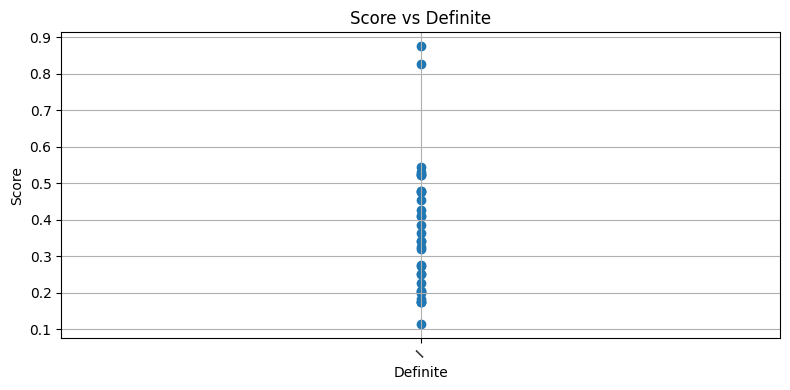

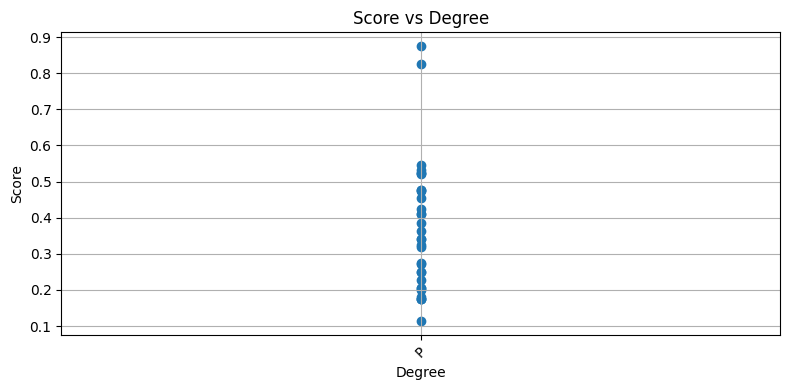

In [158]:
plot_morph('ADJ')

{'Number', 'Abbr', 'Gender', 'Case', 'Definite'}


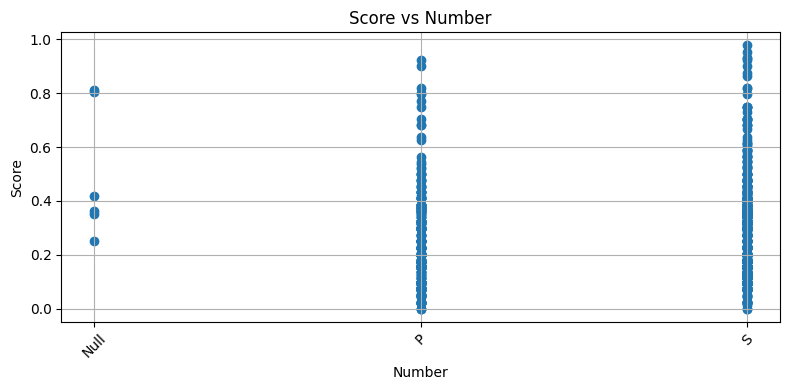

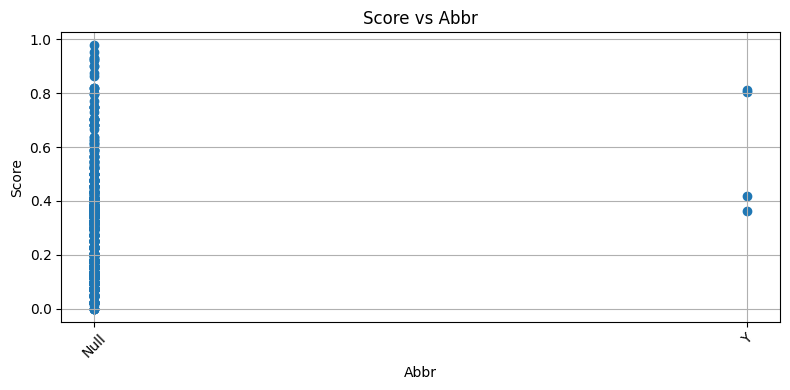

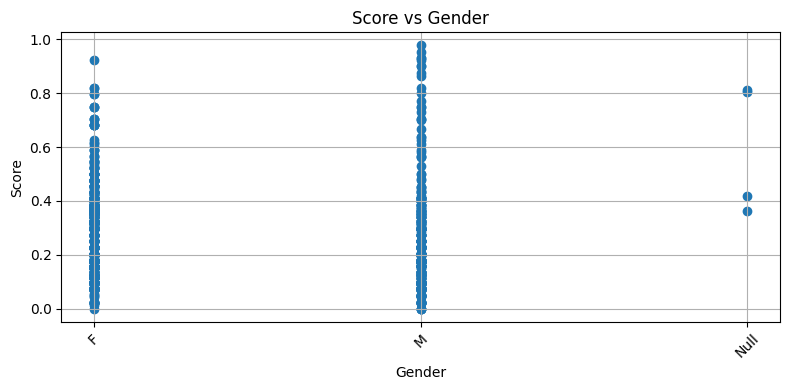

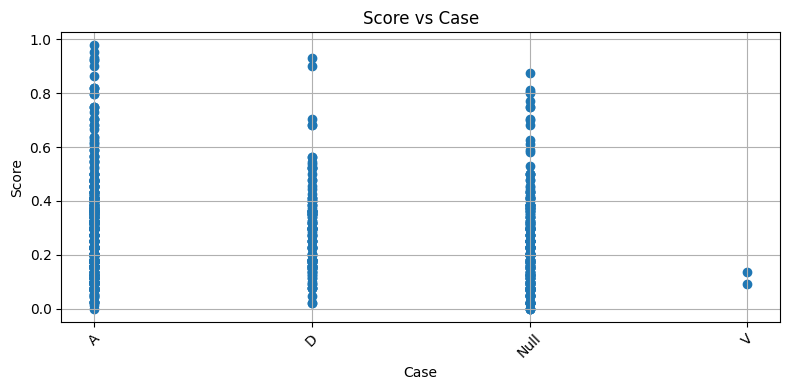

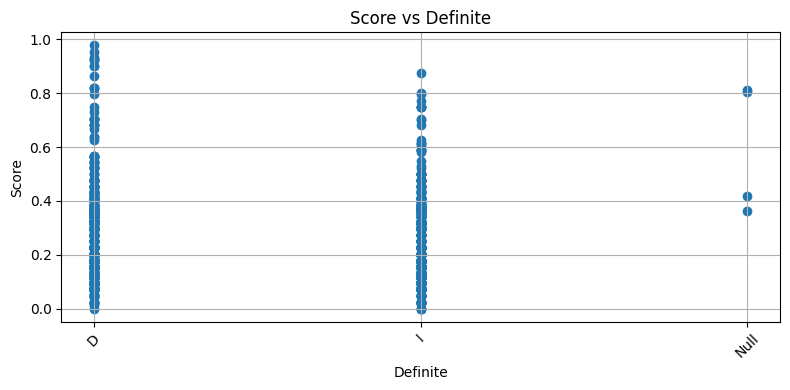

In [159]:
plot_morph('NOUN')

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(criterion='poisson',random_state=42)
rf_model.fit(X_train, y_train)

l = []
for row in test_data['val_token']:
    text = row[0]  # primul token din fiecare listă
    if text.is_oov:
        l.append(1)
    else:
        l.append(0)
test_data['oov'] = l

X_test = test_data[['avg_token_freq_score', 'len_lemma_token','pos_token', 'l2_vector_norm', 'oov']] 
X_test = X_test[X1.columns]
y_pred = rf_model.predict(X_test)

df_output = pd.DataFrame({
    "Id": test_data.index,  # presupunem că indexul din test.csv este Id-ul
    "complexity": y_pred
})

# Salvează în CSV
df_output.to_csv("predicted_randomForest.csv", index=False)

In [179]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(criterion='poisson',random_state=42)
model.fit(X_train, y_train)


X_test = test_data[['avg_token_freq_score', 'pos_token', 'l2_vector_norm', 'oov']] 
X_test = X_test[X1.columns]
y_pred = model.predict(X_test)

df_output = pd.DataFrame({
    "Id": test_data.index,  # presupunem că indexul din test.csv este Id-ul
    "complexity": y_pred
})

# Salvează în CSV
df_output.to_csv("predicted_multilinear2.csv", index=False)

In [2]:
!pip install gensim

     ---------------------------------------- 0.0/24.0 MB ? eta -:--:--
     ---------------------------------------- 0.1/24.0 MB 1.3 MB/s eta 0:00:19
     ---------------------------------------- 0.2/24.0 MB 2.1 MB/s eta 0:00:12
      --------------------------------------- 0.4/24.0 MB 2.7 MB/s eta 0:00:09
     - -------------------------------------- 0.6/24.0 MB 3.5 MB/s eta 0:00:07
     - -------------------------------------- 0.9/24.0 MB 4.3 MB/s eta 0:00:06
     -- ------------------------------------- 1.2/24.0 MB 4.5 MB/s eta 0:00:06
     -- ------------------------------------- 1.5/24.0 MB 4.8 MB/s eta 0:00:05
     -- ------------------------------------- 1.8/24.0 MB 4.9 MB/s eta 0:00:05
     --- ------------------------------------ 2.0/24.0 MB 5.0 MB/s eta 0:00:05
     --- ------------------------------------ 2.3/24.0 MB 5.0 MB/s eta 0:00:05
     ---- ----------------------------------- 2.6/24.0 MB 5.2 MB/s eta 0:00:05
     ----- ---------------------------------- 3.0/24.0 MB 5

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: C:\Users\Daniel\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import os
from gensim.models import Word2Vec
word2vec = Word2Vec.load('Word2Vec/SG_300_25_15/SG_300_25_15.model')
